In [2]:
import random
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc

2023-10-25 20:12:11.177954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
base_dir = '../data'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [4]:
image_dim = 100  # change as needed

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_dim, image_dim, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [5]:
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [6]:
train_datagen = ImageDataGenerator(rescale = 1.0/255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(image_dim, image_dim))

test_datagen  = ImageDataGenerator(rescale = 1.0/255)
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(image_dim, image_dim))

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [9]:
history = model.fit(
            train_generator, # pass in the training generator
            steps_per_epoch=50,
            epochs=30,
            validation_data=test_generator, # pass in the validation generator
            validation_steps=20,
            verbose=1
            )

Epoch 1/30
50/50 [==============================] - 21s 426ms/step - loss: 0.1223 - accuracy: 0.9530 - val_loss: 0.4207 - val_accuracy: 0.8375
Epoch 2/30
50/50 [==============================] - 18s 351ms/step - loss: 0.1591 - accuracy: 0.9348 - val_loss: 0.5059 - val_accuracy: 0.8375
Epoch 3/30
50/50 [==============================] - 19s 389ms/step - loss: 0.1323 - accuracy: 0.9550 - val_loss: 0.4686 - val_accuracy: 0.8450
Epoch 4/30
50/50 [==============================] - 20s 407ms/step - loss: 0.1309 - accuracy: 0.9529 - val_loss: 0.5638 - val_accuracy: 0.8300
Epoch 5/30
50/50 [==============================] - 19s 380ms/step - loss: 0.0939 - accuracy: 0.9679 - val_loss: 0.6059 - val_accuracy: 0.8225
Epoch 6/30
50/50 [==============================] - 17s 349ms/step - loss: 0.1752 - accuracy: 0.9300 - val_loss: 0.5263 - val_accuracy: 0.8050
Epoch 7/30
50/50 [==============================] - 19s 380ms/step - loss: 0.1169 - accuracy: 0.9580 - val_loss: 0.5124 - val_accuracy: 0.8250

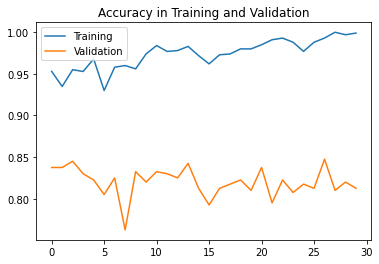

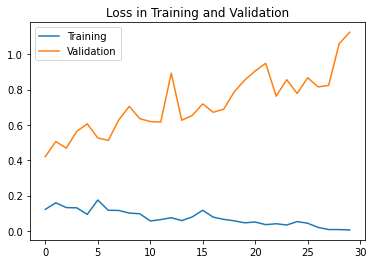

In [27]:
# get the metrics from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

# plot accuracy
plt.plot(epochs, acc, label="Training")
plt.plot(epochs, val_acc, label="Validation")
plt.title('Accuracy in Training and Validation')
plt.legend(loc='upper left')
plt.figure()

# plot loss 
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.title('Loss in Training and Validation')
plt.legend(loc='upper left')

In [11]:
# Filepath must end in '/' and contain benign and malignant directories
# Returns a list of n tuples, [(filename, correct_label)...]
# Possible tweak: change filepath instead of returning error?
def random_images(filepath, n):  
    if filepath[-1] != '/':
        print("ERROR: Filepath does not end in '/'.")
        return
    benign_n = random.randint(0, n // 2)
    malig_n = n - benign_n
    benign_dir, malig_dir = os.listdir(filepath + "benign/"), os.listdir(filepath + "malignant/")
    benign_files, malig_files = random.sample(benign_dir, benign_n), random.sample(malig_dir, malig_n)
    output = [("benign/" + filename, "benign") for filename in benign_files]
    output += [("malignant/" + filename, "malignant") for filename in malig_files]
    random.shuffle(output)
    return output
    

In [21]:
filepath = "../data/test/"
class_labels = ['benign', 'malignant']
n = 100

# Create a higher density of threshold values for smoother curves
threshold_range = [0.5, 0.6, 0.7, 0.8, 0.9]
results = []

# Define arrays to store true positive rates and false positive rates for each threshold
tpr_array = []
fpr_array = []

for threshold in threshold_range:
    false_positives = 0
    false_negatives = 0
    accurate_ct = 0
    y_true = []  # True labels
    y_scores = []  # Model's scores
    images = random_images(filepath, n)

    for file_tuple in images:
        filename, correct_label = file_tuple[0], file_tuple[1]
        img_path = os.path.join(filepath, filename)
        img = image.load_img(img_path, target_size=(image_dim, image_dim))
        x = image.img_to_array(img) / 255
        x = np.expand_dims(x, axis=0)
        images = np.vstack([x])

        classes = model.predict(images, batch_size=10, verbose=0)
        prediction = 1 if classes[0] > threshold else 0  # Use 1 for malignant and 0 for benign

        y_true.append(1 if correct_label == 'malignant' else 0)
        y_scores.append(prediction)

        if prediction == y_true[-1]:
            accurate_ct += 1
        else:
            if prediction == 0 and y_true[-1] == 1:
                false_negatives += 1
            else:
                false_positives += 1

    accuracy = accurate_ct / n
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    results.append((threshold, fpr, tpr, accuracy))
    tpr_array.append(tpr)
    fpr_array.append(fpr)

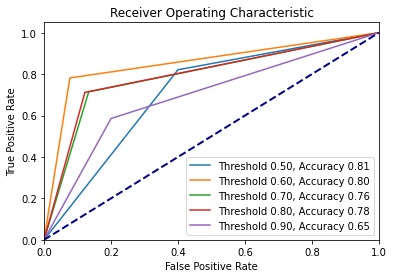

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

plt.figure()
for threshold, fpr, tpr, accuracy in results:
    plt.plot(fpr, tpr, label=f'Threshold {threshold:.2f}, Accuracy {accuracy:.2f}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
